# 1 Reading Data
In this section you will be working on A subset of the data from the Western Collaborative Group Study (described in Rosenman et al. 1975). The WCGS (Western Collaborative Group Study) began in 1960 with 3,524 male volunteers who were employed by 11 California companies. Subjects were 39 to 59 years old and free of heart disease as determined by electrocardiogram. After the initial screening, the study population dropped to 3,154 and the number of companies to 10 because of various exclusions. The cohort comprised both blue- and white-collar employees. At baseline the following information was collected: socio-demographic including age, education, marital status, income, occupation; physical and physiological including height, weight, blood pressure, electrocardiogram, and corneal arcus; biochemical including cholesterol and lipoprotein fractions; medical and family history and use of medications; behavioral data including Type A interview, smoking, exercise, and alcohol use. Later surveys added data on anthropometry, triglycerides, Jenkins Activity Survey, and caffeine use. 

Using [pandas.read_excel](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_excel.html), load the dataset into a DataFrame from the **wcgs_partial.xlsx** file (**You may need to use pip or conda to install openpyxl in addition to pandas module/library**).

Your data contains only the following information: age, arcus (Arcus senilis is a white, gray, or blue looking ring surrounding the cornea. This is commonly seen in elderlies but can also affect people of any age.
Arcus senilis is usually harmless, although it is sometimes a symptom of high cholesterol in people below 45 years old.), BMI (basic metabolic rate),	chol (cholestrol), 	height, 	ncigs (number of cigars),  	sbp (systolic blood pressure), and	weight

Reference : 

Rosenman RH, Brand RJ, Jenkins CD, Friedman M, Straus R, Wurm M (1975). "Coronary Heart Disease in the Western Collaborative Group Study. Final Follow-up Experience of 8 1/2 Years." JAMA, 233(8), 872-7.

In [1]:
# Import required libraries
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Loading Data

In [2]:
wcgs_df = pd.read_excel('wcgs_partial.xlsx', nrows=3142)

# WCGS Multiple Regression Analysis Assignment

#### Dataset: Partial Western Collaborative Group Study (WCGS)
#### Target Variable: Cholesterol (`chol`)
#### Main Predictors: `age`, `bmi`, `sbp`, `ncigs`

---

**Instructions:**   
- Show your code and outputs for all parts.  
- Interpret your results in a biomedical context.

---

## Part 1: Data Setup and Exploration (**5 points**)

- Generate a new Data frame by selecting the columns: `chol`, `age`, `bmi`, `sbp`, `ncigs`
- Display basic statistics and check for missing values (hint: use info(), describe(), isnull()





In [3]:
# Generate a new Data frame with selected features and target 'chol', 'age', 'bmi', 'sbp', 'ncigs'
df = wcgs_df[['chol', 'age', 'bmi', 'sbp', 'ncigs']]

# Display basic statistics and check for missing values
num_null = df.isnull().sum()
print("Number of missing values for each predictor:")
print(num_null, "\n")

df.info()
df.describe()

Number of missing values for each predictor:
chol     0
age      0
bmi      0
sbp      0
ncigs    0
dtype: int64 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3142 entries, 0 to 3141
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   chol    3142 non-null   int64  
 1   age     3142 non-null   int64  
 2   bmi     3142 non-null   float64
 3   sbp     3142 non-null   int64  
 4   ncigs   3142 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 122.9 KB


,chol,age,bmi,sbp,ncigs
count,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000
mean,226.372374,46.274666,24.514472,128.609166,11.574793
std,43.420426,5.518455,2.563803,15.052683,14.491420
min,103.000000,39.000000,11.190612,98.000000,0.000000
25%,197.250000,42.000000,22.955103,120.000000,0.000000
50%,223.000000,45.000000,24.389795,126.000000,0.000000
75%,253.000000,50.000000,25.840160,136.000000,20.000000
max,645.000000,59.000000,38.947369,230.000000,99.000000


## Part 2: Pairwise Relationship Analysis (**15 points total**)

### **Code Implementation** (**3 points**)
### Instructions:
Create a pairwise plot using Seaborn to visualize relationships between all variables in your dataset. This will help you understand the structure of your data before building regression models.

### Your Task:
Use the `sns.pairplot()` function to create a comprehensive visualization of all variable relationships in your dataset.

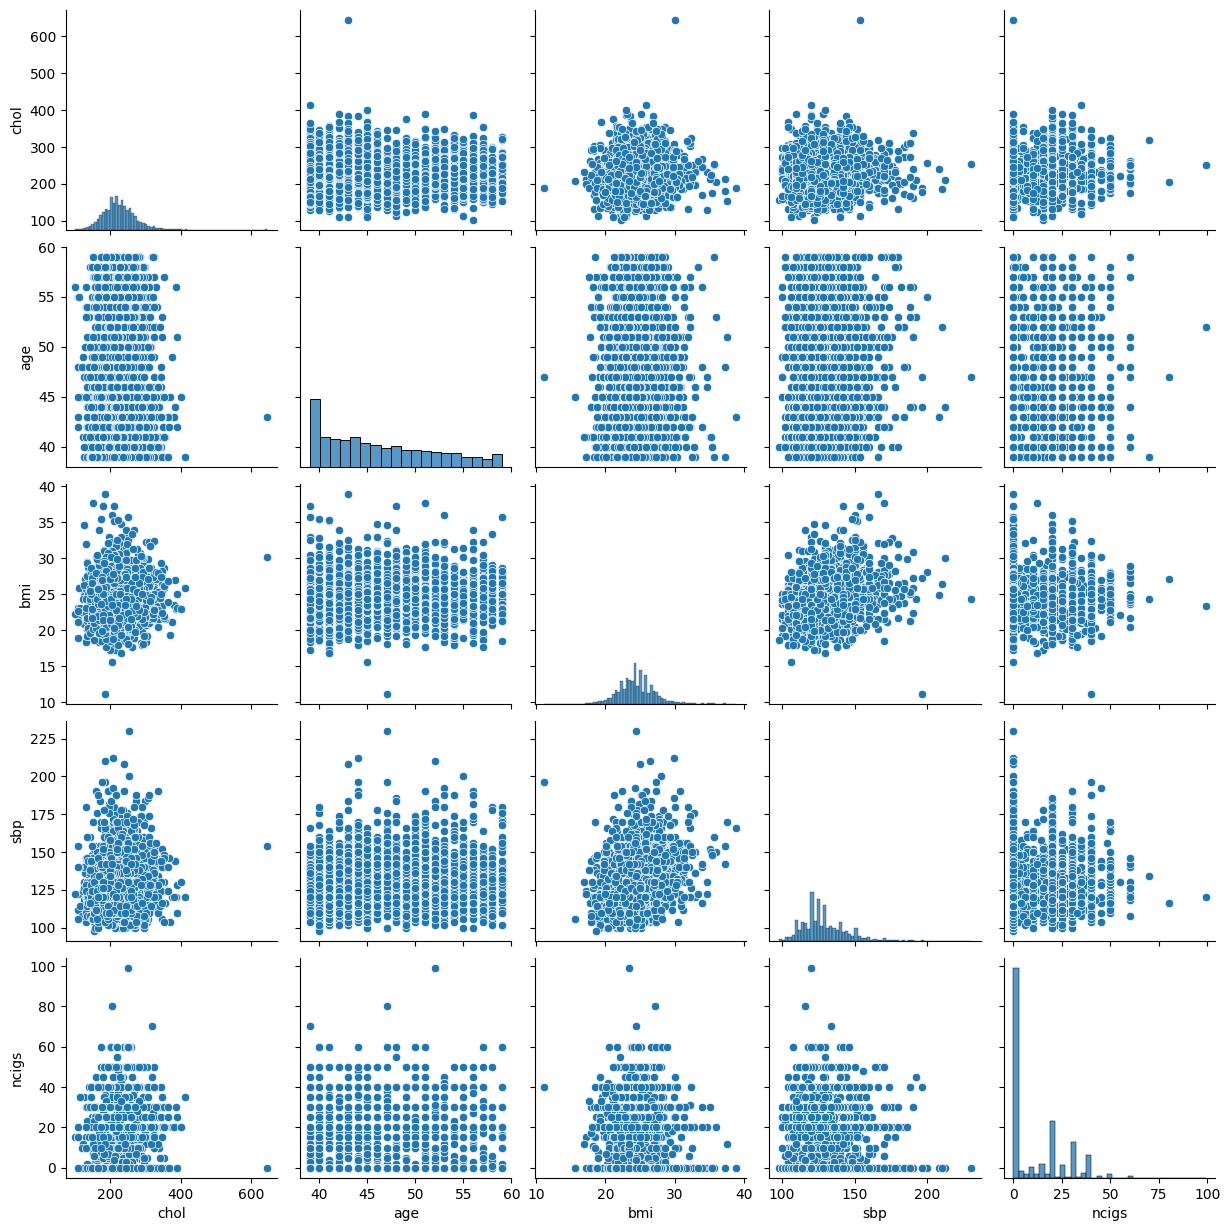

In [4]:
# Creating a pairwise plot in Seaborn (a statistical data visualization)
sns.pairplot(df)


#### **Question 2.1** (**4 points**)
**Examine the diagonal plots (histograms):**
- Which variable appears to have the most normal distribution? 
- Which variable shows the most skewness? In which direction?
- Are there any variables with unusual distributions (e.g., bimodal, heavy tails)?

BMI appears to have the most normal distribution.
ncigs seems the most right skewed.
Age has an unusual distribution, with a continual decrease in count with increasing age (somewhat right skewed).

#### **Question 2.2** (**4 points**)
**Examine the scatter plots for relationships with cholesterol (`chol`):**
- Which predictor shows the strongest linear relationship with cholesterol, if any?
- Which predictor shows the weakest relationship with cholesterol, if any?

None show a strong linear relationship with cholesterol, as all of them have a weak relationship with cholesterol.

#### **Question 2.3** (**4 points**)
**Examine relationships between predictors (multicollinearity check):**
- Which two predictors appear most strongly correlated with each other?
- Why might this correlation be a concern for multiple regression?
- Based on the pairplot, do you expect any multicollinearity issues in your regression model?

bmi and sbp appear the most strongly correlated. This correlation could be an issue and introduce multicollinearity, causing unstable coefficients. However, based on the pairplot, the relationship is not super strong so multicollinearity would be a minor concern.

## Part 3: Multiple Regression Model Fitting (**20 points total**)

### Instructions:
Fit a multiple regression model to predict cholesterol levels using age, BMI, systolic blood pressure, and number of cigarettes per day. Use statsmodels to get detailed statistical output including t-tests, F-tests, and confidence intervals.

### **Code Implementation** (**11 points**)

**Your Task:** 
1. Define your predictor variables (X) and target variable (y)
2. Add an intercept term for statsmodels
3. Fit an OLS model and display the summary

**Hint:** You'll need to import statsmodels, use `sm.add_constant()`, and `sm.OLS().fit()`


In [5]:
# Write your code here
# statsmodel already imported in a prior cell

X = df[['age', 'bmi', 'sbp', 'ncigs']] # predictor variables
y = df['chol'] # target variable: cholestorol

# add an intercept term for statsmodels
X = sm.add_constant(X)

# fit an OLS model
model = sm.OLS(y, X).fit()

# display summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   chol   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     25.24
Date:                Wed, 24 Sep 2025   Prob (F-statistic):           1.31e-20
Time:                        23:37:52   Log-Likelihood:                -16256.
No. Observations:                3142   AIC:                         3.252e+04
Df Residuals:                    3137   BIC:                         3.255e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        140.0778     10.341     13.546      0.0

### **Model Interpretation Questions**

#### **Question 3.1: Coefficient Significance** (**3 points**)
Examine the coefficient table in your model summary:
- Which predictors are statistically significant at $\alpha = 0.05$?
- Which predictor has the largest effect size (absolute coefficient value)?
- Are there any predictors that are NOT significant? If so, which ones?

All the predictors are statisitcally significant with p-values < 0.05.
Of the predictors, bmi has the largest effect size.
There are no predictors that are not significant since all have p < 0.05.


#### **Question 3.2: Clinical Interpretation** (**3 points**)
Choose ONE statistically significant predictor and provide a complete clinical interpretation:
- What is the coefficient value and its units?
- What does this mean in practical terms for a patient?
- Is the relationship positive or negative, and does this make clinical sense?

Predictor: age (years)
The coefficient is 0.5721, with units mg/dL/age
This indicates that for every one year increase in a patients age, their cholesterol level will increase by 0.5721 mg/dL.
The relationship is positive, and it makes sense since aging is correlated with increased cholesterol levels.

#### **Question 3.3: Overall Model Performance** (**3 points**)
Look at the model summary statistics:
- What is the $R^2$ value and what does it tell you?
- Is the overall model statistically significant? (Look at the F-statistic p-value)
- How would you describe this model's performance in predicting cholesterol?

The R^2 is 0.031, and tells you that the model only explains 3.1% of the variability in cholesterol level. The F-statistic p-value is 1.31e-20, which makes the model statistically significant (p < 0.05). The model has poor performance because of its low R^2 score.

## Part 4: Cross-Validation Analysis (**15 points total**)

### Instructions:
Perform 5-fold cross-validation to assess how well your multiple regression model generalizes to unseen data. This will help you understand if your model is overfitting and provide a more realistic estimate of predictive performance.

### **Code Implementation** (**5 points**)

**Your Task:** 
1. Set up 5-fold cross-validation with shuffling
2. Use sklearn's LinearRegression and cross_val_score
3. Calculate and display invidual $R^2$ for each fold along with the mean and standard deviation of CV $R^2$ scores

**Hint:** You'll need `KFold`, `LinearRegression`, and `cross_val_score` from sklearn. Use `scoring='r2'` and set `random_state=42` for reproducibility.

In [6]:
# Cross-validation using sklearn

# perform 5-fold cross-validation to asses how well your multiple regression model generalizes to unseen data
# set up 5-fold cross-validation with shuffling
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# use sklearn's LinearRegression
lr = LinearRegression()

# use cross_val_score
r2_scores = cross_val_score(lr, X, y, cv=kf, scoring='r2')

# calculate R^2 scores for each fold along with the mean and standard deviation of CV R^2 scores
print("R^2 scores for each fold: ", r2_scores)
print("Mean R^2 score: ", np.mean(r2_scores))
print("Standard Deviation of R^2 scores: ", np.std(r2_scores))

R^2 scores for each fold:  [0.01284436 0.01676055 0.03535155 0.02116448 0.04336927]
Mean R^2 score:  0.025898044077677086
Standard Deviation of R^2 scores:  0.01158370945622439


### **Cross-Validation Interpretation Questions**

#### **Question 4.1: CV Performance Assessment** (**5 points**)
Analyze your cross-validation results:
- What is the mean CV $R^2$ and its standard deviation?
- How does the CV $R^2$ compare to your $R^2$ from Part 3?
- What does the standard deviation tell you about model stability across folds?

The mean CV R^2 is 0.0259 and the STD is 0.0116. The R^2 score is lower than part 3. The STD tells you that the model isn't stable relative to the mean.

#### **Question 4.2: Generalization and Overfitting** (**5 points**)
Based on your CV results:
- Is there evidence of overfitting? Explain your reasoning.
- How confident are you that this model will perform equally on new, unseen patients?
- If the CV $R^2$ is much lower than $R^2$ in part 3, what might this suggest about your model?

There is not much evidence of overfitting because the CV R^2 value here is similar to that in part 3, even with more folds. I am somewhat confident that this model can perform at a similar performance on unseen patient data, with some variability. But if the CV R^2 is much lower than that in part 3, then the model is likely overfitting to the training data.



## Part 5: Cross-Validation Visualization (**15 points total**)

### Instructions:
Create visualizations to better understand the variability and distribution of your cross-validation results. You'll create both a boxplot and a bar chart to show different perspectives on CV performance.

### **Code Implementation** (**10 points**)

**Your Task:** 
1. Create a figure with two subplots side by side
2. Left subplot: Vertical boxplot showing CV $R^2$ distribution with a horizontal dashline overlaid parallel to the x axis representing mean $R^2$. Add labesl and title and legend for mean.
3. Right subplot: Bar chart showing individual fold performance with annotations. Add a horizontal dashline overlaid parallel to the x axis representing mean $R^2$. Add labesl and title and legend for mean.

**Hint:** You'll need `plt.figure()`, `plt.subplot()`, `plt.boxplot()`, `plt.bar()`, and `plt.scatter()`. Don't forget to add mean lines, labels, and annotations.

0.025898044077677086


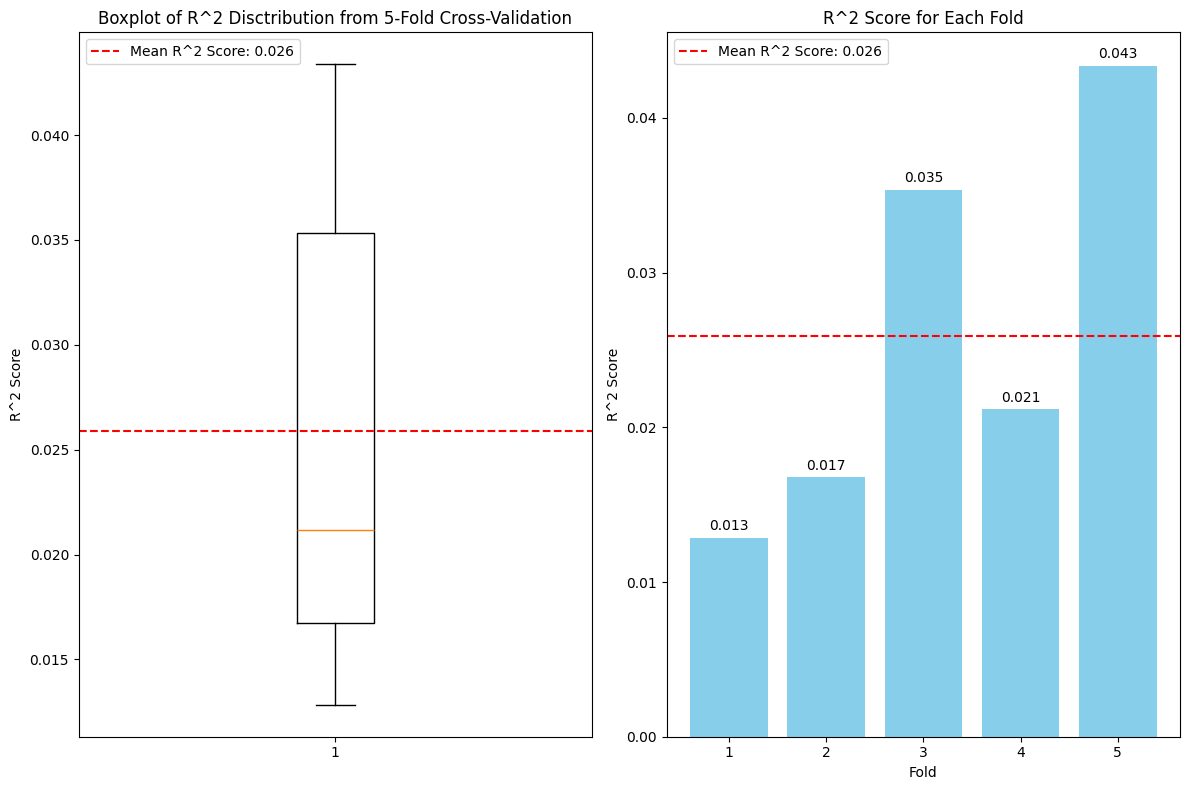

In [7]:
#Write your code here

r2_mean = np.mean(r2_scores)
print(r2_mean)

# create a figure with two subplots
plt.figure(figsize=(12, 8))

# LEFT SUBPLOT
plt.subplot(1, 2, 1)
plt.title('Boxplot of R^2 Disctribution from 5-Fold Cross-Validation')
plt.ylabel('R^2 Score')
plt.boxplot(r2_scores)

# add horizontal dashline for mean R^2
plt.axhline(y=r2_mean, color='r', linestyle='--', label='Mean R^2 Score: 0.026')
plt.legend(loc='upper left')


# RIGHT SUBPLOT
plt.subplot(1, 2, 2)
plt.title('R^2 Score for Each Fold')
plt.ylabel('R^2 Score')
plt.xlabel('Fold')

folds = np.arange(1, 6)
plt.xticks(folds)

# bar chart showing individual fold performance
plt.bar(folds, r2_scores, color='skyblue')

# add a horizontal dashline for mean R^2
plt.axhline(y=r2_mean, color='r', linestyle='--', label='Mean R^2 Score: 0.026')

# add quantitative labels on top of each bar
# (used AI to help with formatting the values)
for i, score in enumerate(r2_scores):
    plt.text(folds[i], score+0.0005, f"{score:.3f}", ha='center')

plt.legend()
plt.tight_layout()


### **Visualization Interpretation Questions**

#### **Question 5.1: Distribution Analysis** (**2.5 points**)
Examine your boxplot (left subplot):
- What does the boxplot tell you about the distribution of CV $R^2$ scores?
- Are there any outliers in your CV performance?

The boxplot tells you the CV R^2 score variability.
There are no outliers in the performance.

#### **Question 5.2: Fold-by-Fold Analysis** (**2.5 points**)
Examine your bar chart (right subplot):
- Which fold performed best? Which performed worst?
- Is the variation between folds concerning or acceptable?

Fold 5 performed the best and fold 1 performed the worst. The variation is acceptable since there are no outliers.

## Part 6: Model Diagnostic Plot - Fitted vs Actual (**15 points total**)

### Instructions:
Create a diagnostic plot to assess how well your model's predictions match the actual observed values. This "fitted vs actual" plot is crucial for evaluating model performance and identifying potential issues with your regression model.

### **Code Implementation** (**10 points**)

**Your Task:** 
1. Fit a LinearRegression model on the full dataset and generate predictions
2. Create a scatter plot with fitted values on x-axis and actual values on y-axis
3. Add a diagonal reference line (perfect prediction line) from min to max values
4. Set equal axis limits for proper comparison
5. Add $R^2$ value as text annotation with a background box
6. Include proper labels, title, and formatting

**Specific Requirements:**
- Use blue scatter points with transparency (alpha=0.6)
- Red dashed diagonal line (lw=2)
- Set axis limits from minimum value to 450
- Place $R^2$ text in upper left corner (0.05, 0.95) with white background box
- Figure size should be (12, 4)

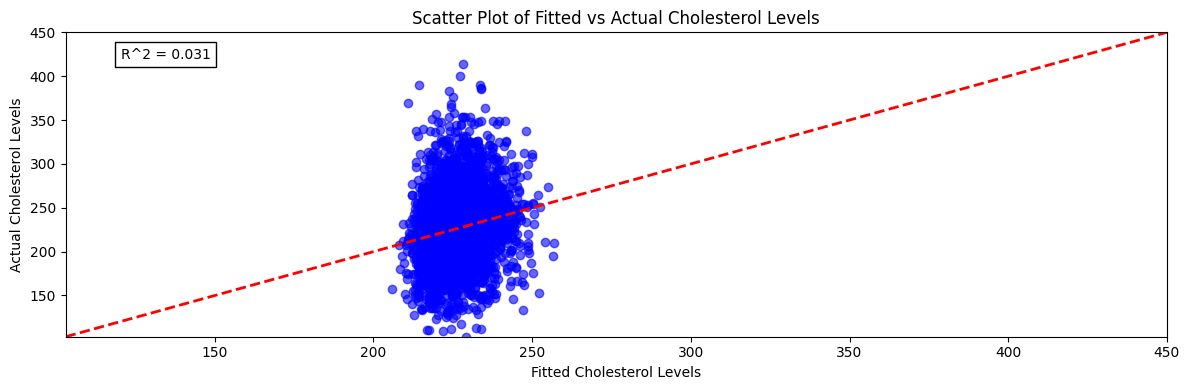

In [8]:
# Write your code here
# already fitted model in a previous cell

# fit model on dataset
lr.fit(X, y)
y_pred = lr.predict(X)

# create a scatter plot
plt.figure(figsize=(12, 4))
plt.scatter(y_pred, y, color='blue', alpha=0.6)

# set axis limits
min_val = min(y.min(), y_pred.min())
max_val = 450
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)

# add a diagonal reference line
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)

# add R^2 text
# used AI to decide to use r2_score function from sklearn as well as for formatting the text box
r2 = r2_score(y, y_pred)
plt.text(0.05, 0.95, f'R^2 = {r2:.3f}', transform=plt.gca().transAxes, 
       ha='left', va='top', bbox=dict(facecolor='white'))

# add title and labels
plt.title('Scatter Plot of Fitted vs Actual Cholesterol Levels')
plt.xlabel('Fitted Cholesterol Levels')
plt.ylabel('Actual Cholesterol Levels')

plt.tight_layout()


### **Diagnostic Plot Interpretation Questions**

#### **Question 6.1: Model Fit Assessment** (**3 points**)
Examine your fitted vs actual plot:
- How closely do the points follow the diagonal red line?
- Are there any systematic patterns or deviations from the diagonal line?

The points don’t align closely with the red line, since most are concentrated within a narrow range. Predicted cholesterol values cluster between 200–250, whereas observed values span from about 100 up to 400. Still, many observed values lie close to the diagonal, suggesting no strong systematic deviations.

#### **Question 6.2: Prediction Quality** (**2 points**)
Based on the scatter pattern:
- For which range of cholesterol values does the model predict best/worst?
- Are there any obvious outliers (points far from the diagonal)?
- Would you trust this model to make predictions for new patients? Why or why not?

The model performs reasonably only for cholesterol values between 200–250, but poorly at the extremes, with clear outliers (e.g., 400). Its very low R² (~3.1%) shows it explains almost none of the variation, making it unreliable for patient use.


## Part 7: Model Diagnostic Plot - Fitted vs Residuals (**15 points total**)

### Instructions:
Create a residual plot to check key regression assumptions including linearity, homoscedasticity (constant variance), and identify potential outliers. This diagnostic plot is essential for validating whether your regression model is appropriate for the data.

### **Code Implementation** (**10 points**)

**Your Task:** 
1. Calculate residuals (actual - predicted values)
2. Create a scatter plot with fitted values on x-axis and residuals on y-axis
3. Add a horizontal zero line (red dashed) to show perfect predictions
4. Add horizontal reference lines at $\pm$1 and $\pm$2 standard deviations
5. Include proper labels, legend, grid, and formatting

**Specific Requirements:**
- Use green scatter points with transparency (alpha=0.6)
- Red dashed zero line (lw=2) with label 'Zero line'
- Orange dotted lines (alpha=0.7) for $\pm$1 SD with labels
- Orange dotted lines (alpha=0.5) for $\pm$2 SD with labels  
- Include legend and light grid (alpha=0.3)
- Figure size should be (12, 4)
- Use `plt.tight_layout()` for proper spacing

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

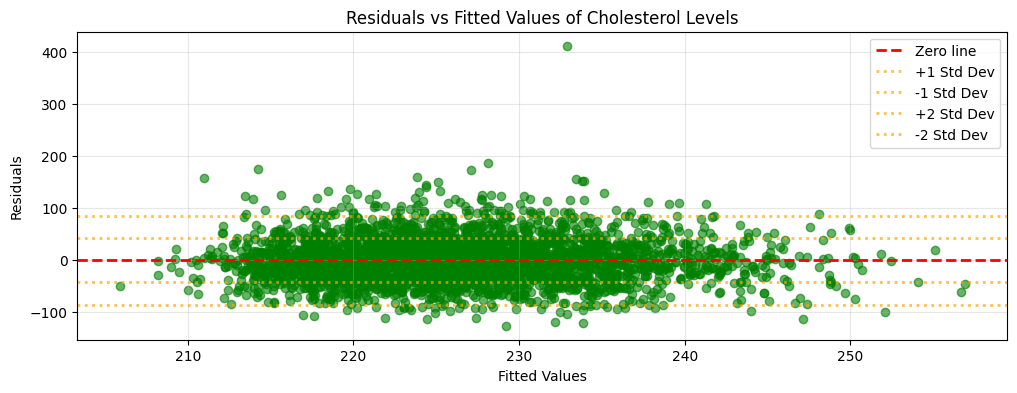

In [9]:
# Write your code here

# calculate residuals
residuals = y - y_pred

# create a scatter plot using green scatter points with transparency (alpha=0.6) with fitted values on x-axis and residuals on y-axis
plt.figure(figsize=(12, 4))

# add title and labels
plt.title('Residuals vs Fitted Values of Cholesterol Levels')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')

plt.scatter(y_pred, residuals, color='green', alpha=0.6)

# add a horizontal reference line at y=0
plt.axhline(y=0, color='r', linestyle='--', lw=2, label='Zero line')

# residual standard deviation
residual_std = np.std(residuals)

# add +/- 1 SD
plt.axhline(y=residual_std, color='orange', linestyle=':', lw=2, alpha=0.7, label='+1 Std Dev')
plt.axhline(y=-residual_std, color='orange', linestyle=':', lw=2, alpha=0.7, label='-1 Std Dev')

# add +/- 2 SD
plt.axhline(y=2*residual_std, color='orange', linestyle=':', lw=2, alpha=0.7, label='+2 Std Dev')
plt.axhline(y=-2*residual_std, color='orange', linestyle=':', lw=2, alpha=0.7, label='-2 Std Dev')

# include legend and light grid (alpha = 0.3)
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout


### **Residual Plot Interpretation Questions**

#### **Question 7.1: Assumption Checking** (**3 points**)
Examine your fitted vs residuals plot:
- Do the residuals appear randomly scattered around zero (linearity assumption)?
- Is the spread of residuals roughly constant across all fitted values?
- Are there any obvious patterns, curves, or funnel shapes in the residuals?

Yes, the residuals are randomly distributed around 0. However, they are more concentrated in the 210–240 range rather than evenly spread across all fitted values. No clear patterns or curves are visible.

#### **Question 7.2: Outlier Detection** (**2 points**)
Look at the standard deviation reference lines:
- Are there any points beyond $\pm$2 SD that might be outliers?
- Do most residuals fall within $\pm$1 SD as expected?

Yes, there are outliers, mostly lying 2 SD above zero, while the majority of residuals fall within 1 SD as expected.

## Part 8: Interaction Term Analysis (**20 points total**)

### Instructions:
Explore whether the effect of smoking on cholesterol depends on a patient's age by adding an interaction term to your regression model. You'll compare a main effects model with an interaction model to see if the interaction significantly improves prediction.

### **Code Implementation** (**12 points**)

**Your Task:** 
1. Create an age × smoking interaction term (age multiplied by ncigs)
2. Set up two models: main effects only vs. main effects + interaction
3. Fit both models using statsmodels OLS
4. Compare model performance ($R^2$, F p-values)
5. Extract and test the significance of the interaction coefficient

**Specific Requirements:**
- Create interaction term: `df['age_smoking_interaction'] = df['age'] * df['ncigs']`
- Model 1: age, bmi, sbp, ncigs (main effects only)
- Model 2: age, bmi, sbp, ncigs, age_smoking_interaction
- Print $R^2$ and F p-values for both models
- Extract interaction coefficient, t-statistic, and p-value
- Include conditional statement to report significance
- Use proper section headers and formatting


In [10]:
# Write your code here

# create interaction term
df['age_smoking_interaction'] = df['age'] * df['ncigs']

# set up Model 1: main effects only
X1 = df[['age', 'bmi', 'sbp', 'ncigs']]

# set up Model 2: main effects + interaction term
X2 = df[['age', 'bmi', 'sbp', 'ncigs', 'age_smoking_interaction']]

# fit both models using statsmodels OLS
X1 = sm.add_constant(X1)
X2 = sm.add_constant(X2)
model1 = sm.OLS(y, X1).fit()
model2 = sm.OLS(y, X2).fit()

# print R^2 and F p-values for both models
print("Model 1 (Main Effects) R^2:", model1.rsquared)
print("Model 1 (Main Effects) F p-value:", model1.f_pvalue)

print("\nModel 2 (With Interaction) R^2:", model2.rsquared)
print("Model 2 (With Interaction) F p-value:", model2.f_pvalue)

# extract stats
interaction_coef = model2.params['age_smoking_interaction']
t2 = model2.tvalues['age_smoking_interaction']
p2 = model2.pvalues['age_smoking_interaction']
print("\nInteraction Coefficient:", interaction_coef)
print("t-statistic:", t2)
print("p-value:", p2)

# report significance of the interaction term
if p2 < 0.05:
    print("\nThe interaction term is statistically significant (p < 0.05).")
else:
    print("\nThe interaction term is not statistically significant in (p >= 0.05).")

Model 1 (Main Effects) R^2: 0.031184902379900903
Model 1 (Main Effects) F p-value: 1.3093832890169565e-20

Model 2 (With Interaction) R^2: 0.03263510057948127
Model 2 (With Interaction) F p-value: 7.216175446918359e-21

Interaction Coefficient: -0.020981104532233757
t-statistic: -2.1682359719568187
p-value: 0.030215700629290895

The interaction term is statistically significant (p < 0.05).


C:\Users\lirou\AppData\Local\Temp\ipykernel_13628\709829921.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['age_smoking_interaction'] = df['age'] * df['ncigs']


### **Interaction Analysis Questions**

#### **Question 8.1: Model Comparison** (**4 points**)
Compare your two models:
- How much did R² increase when adding the interaction term?
- Is the interaction coefficient statistically significant (p < 0.05)?
- Based on the results, does the interaction term improve the model?
- What does the interaction coefficient value tell you about the relationship?

R² increased by 0.0014, and with p < 0.05 the interaction term is statistically significant. The small negative coefficient indicates a slight negative interaction, meaning the effect of cigarettes on cholesterol decreases with age.

#### **Question 8.2: Clinical Interpretation** (**4 points**)
If the interaction is significant, interpret what it means clinically:
- Does the effect of smoking on cholesterol change with age?
- Is smoking more or less harmful for older vs. younger adults?
- How would you explain this finding to a physician or patient?
- Does this result make biological/medical sense?

The effect of smoking on cholesterol decreases with age, showing a stronger harmful impact in younger adults. I’d explain to a physician or patient that smoking is more detrimental for younger people, though the result may seem counterintuitive since older individuals are generally more vulnerable. This could be explained by developmental factors in younger adults or survivor bias among older smokers.


## Part 9: Interaction Visualization (**18 points total**)

### Instructions:
Create two complementary visualizations to understand how the age × smoking interaction affects cholesterol predictions. The left panel shows how the smoking effect changes with age, while the right panel shows actual predicted cholesterol levels for smokers vs non-smokers across different ages.

### **Code Implementation** (**12 points**)

**Your Task:** 
1. Create a figure with two subplots side by side (figsize=(14, 5))
2. **Left panel**: Plot how smoking effect (coefficient) changes with age
   - X-axis: Age (30, 40, 50, 60, 70 years)
   - Y-axis: Smoking effect on cholestrol (mg/dL per cigarette/day)
   - Add value annotations on each point
   - Include horizontal zero line and grid
3. **Right panel**: Plot predicted cholesterol for smokers vs non-smokers
   - Compare non-smokers (0 cigs/day) vs heavy smokers (20 cigs/day)
   - Use average BMI and SBP values for other predictors
   - Include legend and proper styling


**Specific Requirements:**
- Left panel: Red circles with lines, value annotations, horizontal zero line
- Right panel: Green line for non-smokers, red line for smokers, different markers
- Both panels: Proper labels, titles, grids (alpha=0.3)
- Use `plt.tight_layout()` for proper spacing



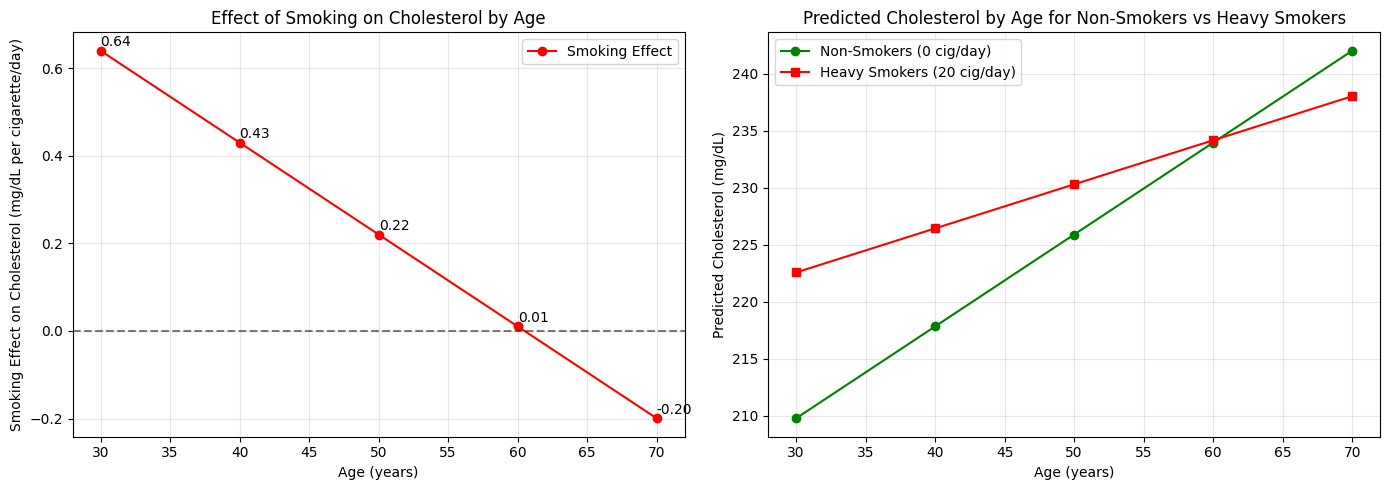

In [11]:
# Write your code here

# retrieve coefficients
age_coef = model2.params['age']
ncigs_coef = model2.params['ncigs']

# create a figure with two subplots
plt.figure(figsize=(14, 5))

# LEFT SUBPLOT
plt.subplot(1, 2, 1)
plt.title('Effect of Smoking on Cholesterol by Age')
plt.xlabel('Age (years)')
plt.ylabel('Smoking Effect on Cholesterol (mg/dL per cigarette/day)')

ages = np.array([30, 40, 50, 60, 70]) # x-axis
smoking_effect = ncigs_coef + interaction_coef * ages
plt.plot(ages, smoking_effect, 'ro-', label='Smoking Effect')

# annotating each point
for i in range(len(ages)):
    plt.text(ages[i], smoking_effect[i]+ 0.01, f'{smoking_effect[i]:.2f}')

# add horizontal reference line at y=0
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.grid(alpha=0.3)
plt.legend()

# RIGHT SUBPLOT
plt.subplot(1, 2, 2)
plt.title('Predicted Cholesterol by Age for Non-Smokers vs Heavy Smokers')
plt.xlabel('Age (years)')
plt.ylabel('Predicted Cholesterol (mg/dL)')

# use average values for bmi and sbp
avg_bmi = df['bmi'].mean()
avg_sbp = df['sbp'].mean()

# plot predicted cholesterol for non-smoker and smokers
heavy_smoker_ncigs = 20
non_smoker_ncigs = 0

non_smoker_chol = (model2.params['const'] +
                   model2.params['age'] * ages +
                   model2.params['bmi'] * avg_bmi +
                   model2.params['sbp'] * avg_sbp +
                   model2.params['ncigs'] * non_smoker_ncigs +
                   model2.params['age_smoking_interaction'] * ages * non_smoker_ncigs)
heavy_smoker_chol = (model2.params['const'] +
                     model2.params['age'] * ages +
                     model2.params['bmi'] * avg_bmi +
                     model2.params['sbp'] * avg_sbp +
                     model2.params['ncigs'] * heavy_smoker_ncigs +
                     model2.params['age_smoking_interaction'] * ages * heavy_smoker_ncigs)

plt.plot(ages, non_smoker_chol, 'g-', marker = 'o', label='Non-Smokers (0 cig/day)')
plt.plot(ages, heavy_smoker_chol, 'r-', marker = 's', label='Heavy Smokers (20 cig/day)')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()

### **Interaction Visualization Questions**

#### **Question 9.1: Smoking Effect Analysis** (**3 points**)
Examine the left panel (smoking effect vs age):
- At what age does smoking have the strongest effect on cholesterol?
- At what age does smoking become less harmful or even beneficial?
- What does the negative slope of this line tell you about the interaction?

At age 30, smoking has the strongest effect, with each cigarette per day raising cholesterol by ~0.64 mg/dL. By around 60, the effect turns negative, meaning heavy smokers show lower cholesterol than non-smokers. The negative slope indicates that the impact of smoking on cholesterol decreases with age.

#### **Question 9.2: Clinical Implications** (**3 points**)
Examine the right panel (predicted cholesterol levels):
- How do the cholesterol trajectories differ between smokers and non-smokers?
- At what age range is the difference between smokers and non-smokers largest?
- Based on these visualizations, what would you tell a 30-year-old smoker vs a 70-year-old smoker about their cholesterol risk?

Heavy smokers start with higher cholesterol, but their levels rise more slowly with age than non-smokers, who begin lower but increase faster. The biggest gap appears around ages 30–35, when smokers have much higher cholesterol; quitting at this age could be especially beneficial. By age 70, smokers may even show lower cholesterol than non-smokers, suggesting the impact of smoking on cholesterol diminishes with age.
